# 历史旱涝数据说明



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
import os
from hydra import compose, initialize

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from past1000.data import HistoricalRecords
from mksci_font import config_font
from past1000.constants import LABELS, STAGES_BINS

palette = plt.get_cmap("coolwarm").reversed()

config_font({"font.size": 9})

# The commented out code is creating an instance of the `HistoricalRecords` class from the `past1000.api.series` module. It is passing the `shp_path` and `data_path` parameters to the constructor of `HistoricalRecords` class using values from `cfg.ds.atlas.shp` and `cfg.ds.atlas.file` respectively.
history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
)

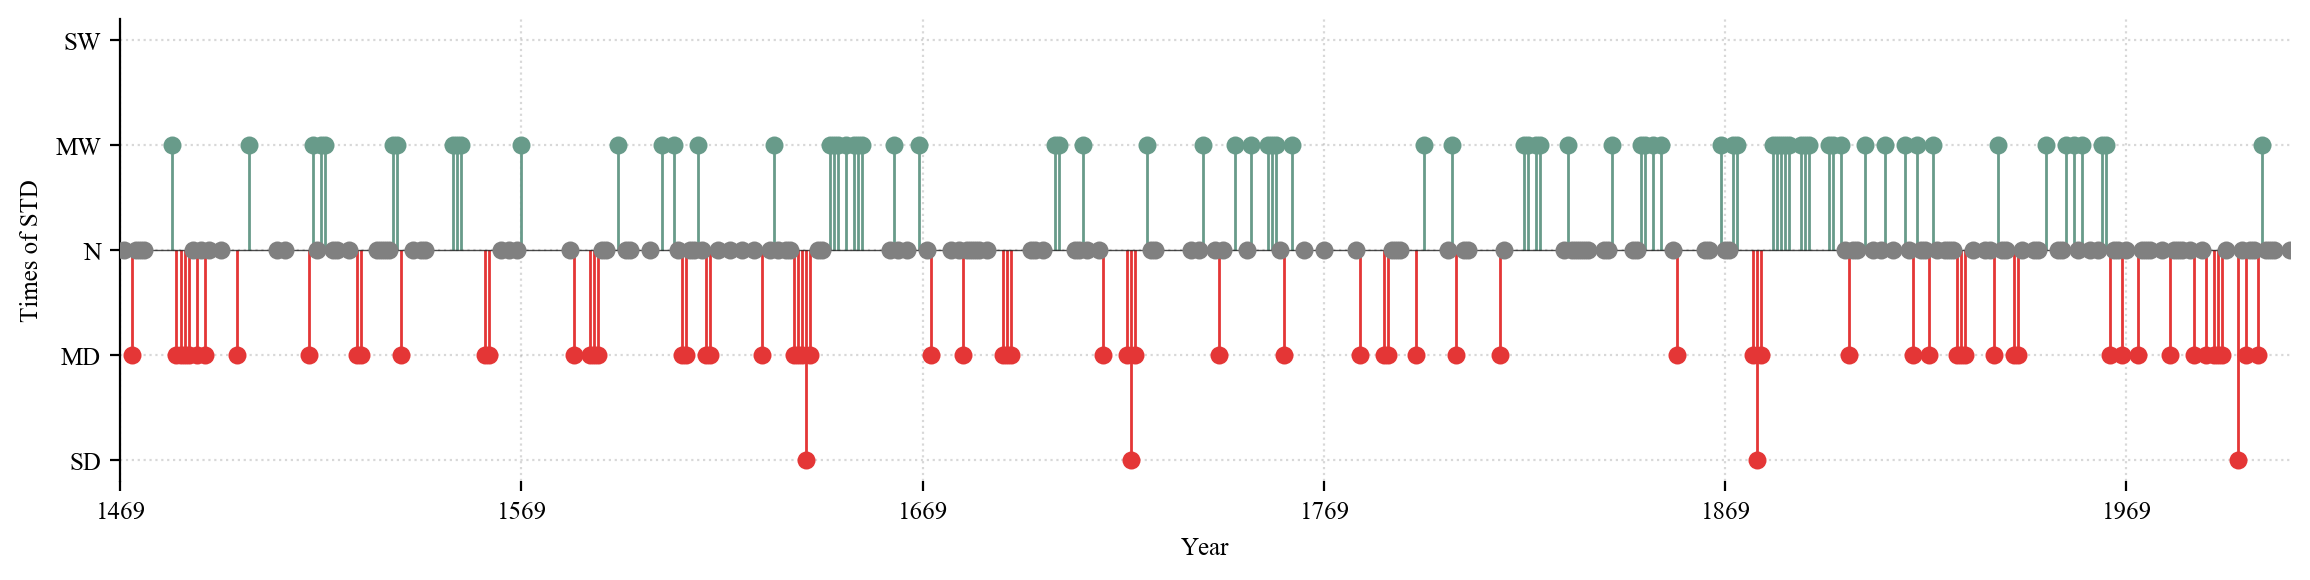

In [4]:
from past1000.utils.plot import plot_std_times
from past1000.constants import TICK_LABELS

data = history.aggregate()

# 绘制历史数据，看看哪些年份有记录
ax = plot_std_times(data)
ax.set_xticks(np.arange(1469, 2010, 100))
ax.set_yticks(np.arange(-2, 2.1, 1))
ax.set_xlim(1469, 2010)
ax.set_yticklabels(TICK_LABELS)
plt.show();

千年之间有记录的年份

# 对比重建数据和历史数据

- 历史数据来自《中国千年旱涝图集》
- 重建数据来自 NOAA 的树轮重建数据


Millennial-scale data reveals collective memory of extreme events The impact of extreme weather events such as droughts and floods is intensifying, one important reason being that society quickly forgets past disasters and develops in disaster-prone areas. This collective memory of disasters has significantly affected a society's vulnerability to them. Still, there has long been a lack of data-driven measurements on how long this collective memory lasts. For the first time, we compared historical records with natural reconstructions over a millennium scale in China's Yellow River Basin, demonstrating that the collective memory of extreme climate lasts about 30 years (two generations). The current Earth System Models (ESMs), however, can not have sufficient spatial and temporal resolution to match this pattern, failing to capture the interactions between humans and extreme events. This finding emphasised the necessity of coupling environmental changes with human social systems and improving ESMs for the deep root of the Anthropocene.

## NOAA 树轮重建数据

In [5]:
from past1000.data import load_nat_data

datasets, uncertainties = load_nat_data(
    folder=cfg.ds.noaa,
    includes=cfg.ds.includes,
    start_year=1000,
    standardize=True,
)
datasets.tail()

Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.


Found 18 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 7 files matching the pattern.


,north-china-precip2010,shanxi2015precip,tan2011precip-noaa,xu2023-asm,qinling2016precip,north-china-temp-precip2011,hexi2019scpdsi
year,,,,,,,
2009,NaN,NaN,NaN,-1.466621,-0.568723,NaN,-0.809462
2010,NaN,NaN,NaN,1.170888,0.307108,NaN,0.515620
2011,NaN,NaN,NaN,1.248765,NaN,NaN,-1.255668
2012,NaN,NaN,NaN,-1.204711,NaN,NaN,NaN
2013,NaN,NaN,NaN,0.140132,NaN,NaN,NaN


In [6]:
from past1000.mc import combine_reconstructions, plot_combined_reconstruction
from mksci_font import config_font

combined, trace = combine_reconstructions(datasets, uncertainties)
combined.head()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.


,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,-0.474,0.444,-1.327,0.350
1001,-0.068,0.464,-0.925,0.814
1002,0.124,0.554,-0.914,1.176
1003,-0.298,0.661,-1.522,0.952
1004,-0.912,0.655,-2.137,0.330


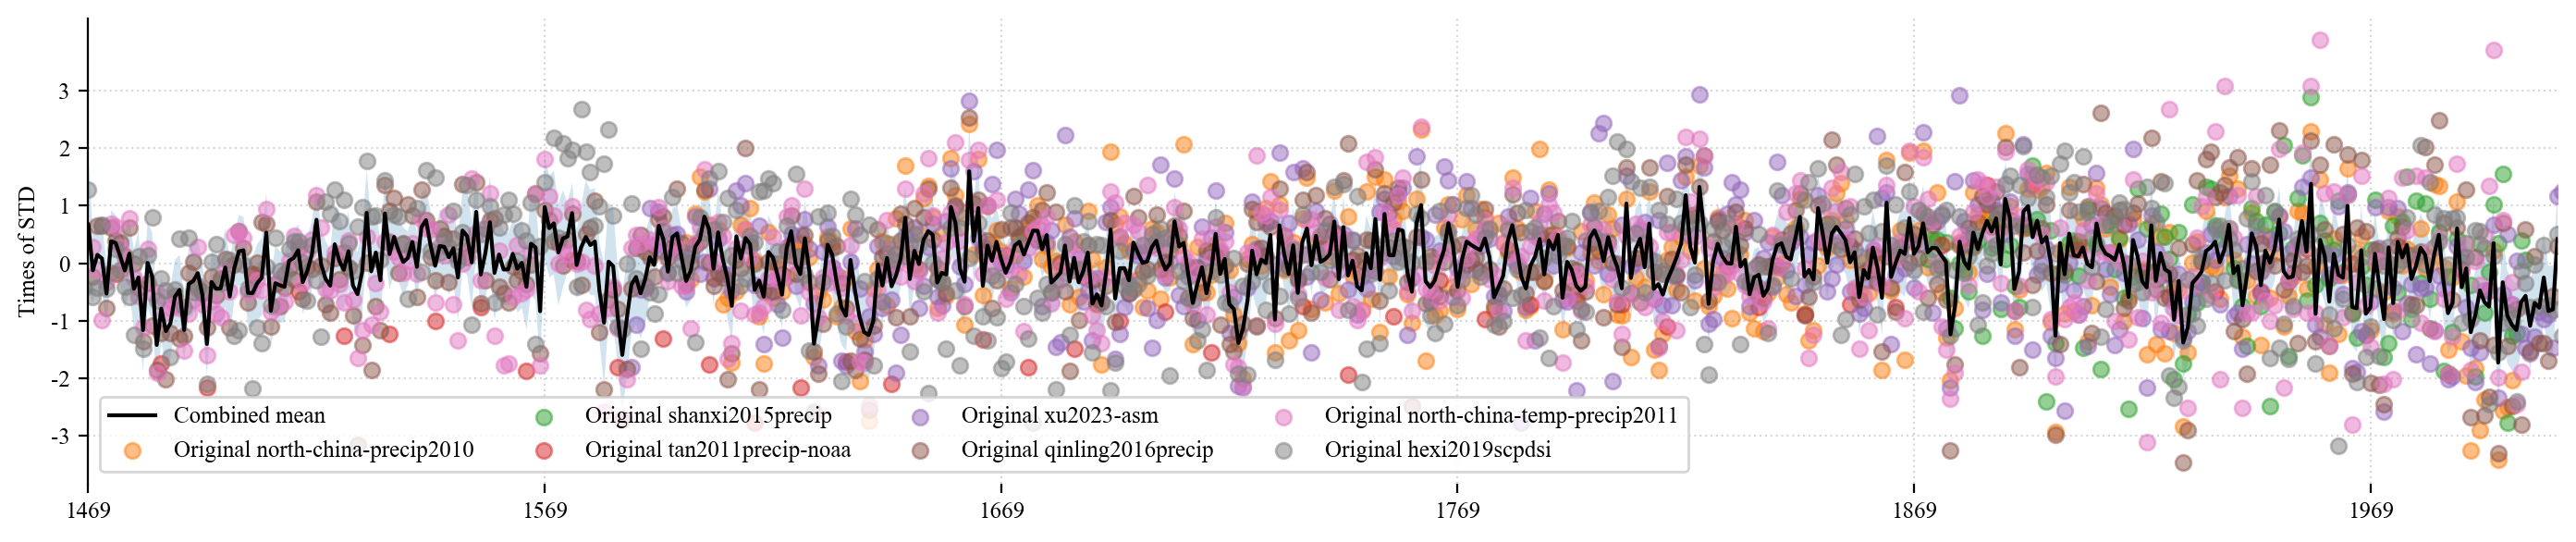

In [7]:
df = history.merge_with(combined)

fig, ax = plt.subplots(figsize=(14, 3), tight_layout=True)
ax = plot_combined_reconstruction(combined=combined, data=datasets, ax=ax)
# history.plot(ax=ax, color="red", ls=":", label="Historical Mean")
ax.set_ylabel("Times of STD")
ax.legend(ncol=4, loc="lower left", fontsize=9)
ax.set_xlim(1469, 2010)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.grid(True, alpha=0.3, ls=":", color="gray")
ax.set_xticks(np.arange(1469, 2010, 100))
ax.set_yticks(np.arange(-3, 3.1, 1))
plt.show();

我们在中国北方选取了1000-2000年的历史数据，并将其与树轮重建数据进行了对比。我们发现，树轮重建数据与历史数据的相关性在以窗口大小为33到40年之间达到较高水平。

这说明，历史记载倾向于以30年左右的时间尺度感知气候变化。

这里我们还可以用一张综合图来说明情况。

由于一般需要5个样本，计算标准差才有意义，所以我们的 `min_periods` 参数比 `windows` 至少要小 5。













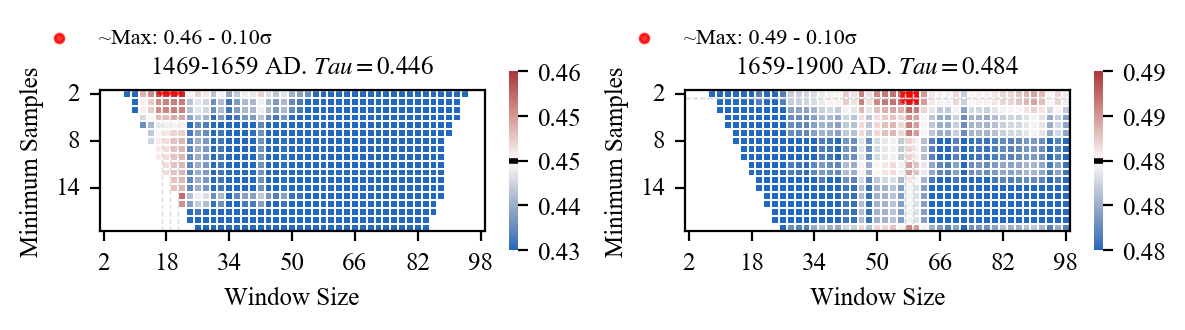

In [8]:
from past1000.compare import experiment_corr_2d
import matplotlib.pyplot as plt
from past1000.constants import STAGE1, STAGE2, END
from past1000.filters import calc_std_deviation

history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
)

METHOD = "kendall"
SIDE = "right"

fig, axs = plt.subplots(1, 2, figsize=(6, 2.5), tight_layout=True)
axs = axs.flatten()
# 实验参数
slice1 = slice(STAGE1, STAGE2)
slice2 = slice(STAGE2, END)

# 四次对比实验
for i, slice_now in enumerate([slice1, slice2]):
    data1, data2 = history.aggregate("mode", inplace=True).merge_with(
        combined["mean"], time_range=slice_now, split=True
    )
    ax = axs[i]
    df, r_benchmark, ax = experiment_corr_2d(
        data1=data1,
        data2=data2,
        time_slice=slice_now,
        corr_method=METHOD,
        filter_func=calc_std_deviation,
        filter_side=SIDE,
        ax=ax,
        penalty=False,
        n_diff_w=5,
        std_offset=0.1,
    )
    ax.set_title(
        f"{slice_now.start}-{slice_now.stop} AD. $Tau={r_benchmark:.3f}$",
        fontsize=9,
    )
    ax.locator_params(axis="x", nbins=9)  # x轴最多9个主刻度
    ax.locator_params(axis="y", nbins=4)  # y轴最多9个主刻度
    ax.tick_params(axis="both", rotation=0)
plt.show();

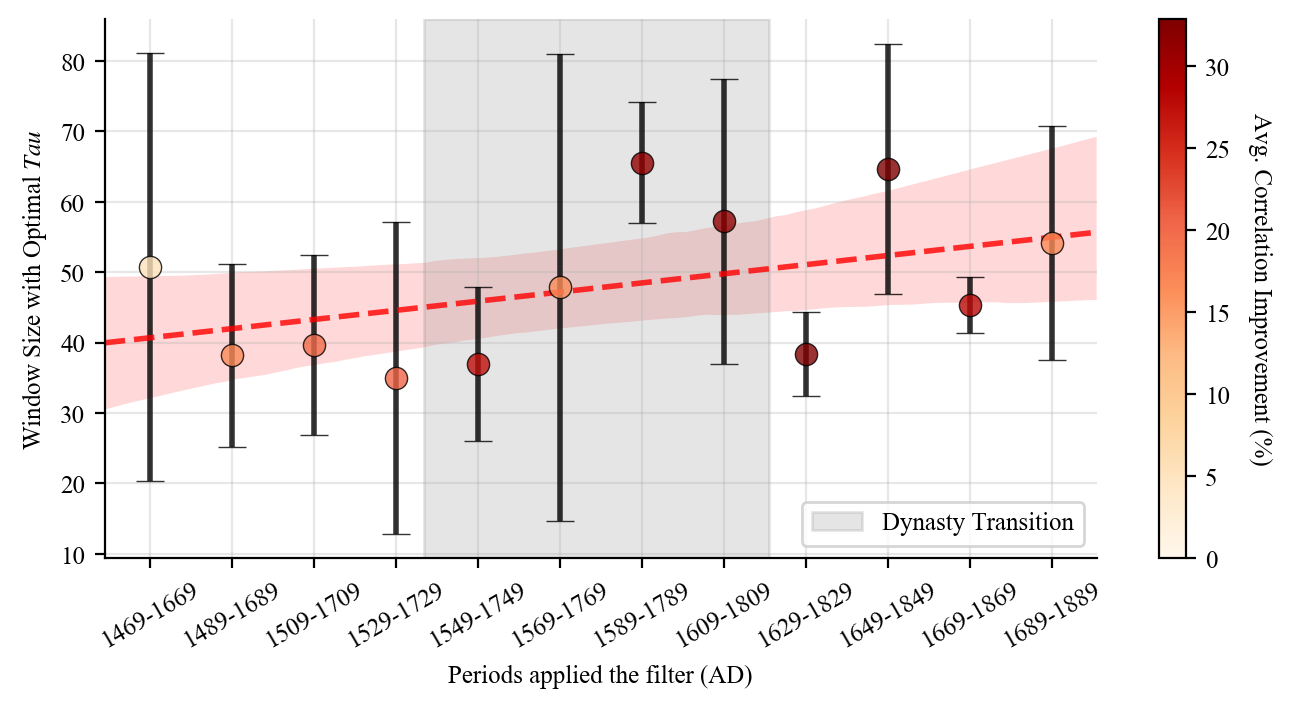

In [9]:
from past1000.compare import sweep_slices
from past1000.filters import calc_std_deviation
from past1000.compare import sweep_max_corr_year

import matplotlib.pyplot as plt
from past1000.utils.plot import plot_correlation_windows

METHOD = "kendall"

# 生成所有可能的300年窗口
slices, mid_year, slice_labels = sweep_slices(
    start_year=STAGE1,
    window_size=200,
    step_size=20,
    end_year=END,
)

data1, data2 = history.merge_with(combined["mean"], split=True)
max_corr_year, max_corr = sweep_max_corr_year(
    data1=data1,
    data2=data2,
    slices=slices,
    corr_method=METHOD,
    windows=np.arange(2, 100),
    min_periods=np.repeat(5, 98),
    filter_func=calc_std_deviation,
)

# 使用函数
ax = plot_correlation_windows(
    max_corr_year,
    max_corr,
    mid_year,
    slice_labels,
)
lims = ax.get_xlim()
ax.axvspan(1636, 1720, color="gray", alpha=0.2, label="Dynasty Transition")
ax.set_xlim(lims)
ax.legend()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show();

### 综合作图

In [ ]:
fig = plt.figure(figsize=(6, 4), constrained_layout=False)  # 增加高度

gs = fig.add_gridspec(ncols=2, nrows=2, height_ratios=[1, 1.2])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# 四次对比实验
for i, slice_now in enumerate([slice1, slice2]):
    ax = [ax1, ax2][i]
    df, r_benchmark, ax = experiment_corr_2d(
        data1=data1,
        data2=data2,
        time_slice=slice_now,
        corr_method=METHOD,
        filter_func=calc_std_deviation,
        filter_side=SIDE,
        ax=ax,
        penalty=False,
        n_diff_w=5,
        std_offset=0.05,
    )
    ax.set_title(
        f"{slice_now.start}-{slice_now.stop} AD. $Tau={r_benchmark:.3f}$",
        fontsize=9,
    )
    ax.locator_params(axis="x", nbins=9)  # x轴最多9个主刻度
    ax.locator_params(axis="y", nbins=4)  # x轴最多9个主刻度
    ax.tick_params(axis="both", rotation=0)


# 绘制不同历史时期的窗口图
# 使用函数
# 使用函数
ax3 = plot_correlation_windows(
    max_corr_year,
    max_corr,
    mid_year,
    slice_labels,
    ax=ax3,
)
lims = ax3.get_xlim()
ax3.axvspan(1636, 1720, color="gray", alpha=0.2, label="Dynasty Transition")
ax3.set_xlim(lims)
ax3.legend()
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.legend()

ax2.set_ylabel("")
plt.tight_layout()
plt.show();